### Generating Data

Below we choose 100 different starting points for the Lorenz system and calculate the trajectory for 8 seconds in time. We will use this to train our neural network. This will allow the network to act as a time-stepper : given a point (x,y,z) it can calculate the new point (x', y', z') dt seconds further in time.

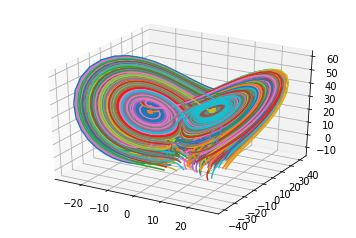

In [106]:
%matplotlib inline

import matplotlib.pylab as plt
import numpy as np
import scipy.integrate
from mpl_toolkits.mplot3d import Axes3D


dt = 0.01  # time step size
T = 8  # total simulation time per initial condition
t = np.arange(start=0, stop=T, step=dt)
num_trajectories = 500  # number of trajectories to simulate

# Set parameters of the lorenz system (rho set later)
b = 8/3
sig = 10


def lorenz(t, x, rho):
    global b, sig
    return [sig * (x[1] - x[0]),  rho * x[0] - x[0]*x[2] - x[1], x[0]*x[1] - b*x[2]]


for i, rho in enumerate([28]): # 10, 28, 40
    fig = plt.figure(i)
    ax = fig.gca(projection='3d')
    for j in range(num_trajectories):
        x0 = 30*np.random.uniform(low=-0.5, high=0.5, size=3)

        # Pass in initial conditions and relative/absolute tolerance
        y_vals = scipy.integrate.odeint(func = lambda t,x: lorenz(t,x, rho), y0=x0, t=t, rtol=1e-10, atol=1e-11, tfirst=True)
        
        
        if j == 0 and i == 0:
            inputs = y_vals[:-1, :]
            outputs = y_vals[1:, :]
        else:
            inputs = np.vstack((inputs, y_vals[:-1, :]))
            outputs = np.vstack((outputs, y_vals[1:, :]))

        ax.plot(xs=y_vals[:, 0], ys=y_vals[:, 1], zs=y_vals[:, 2])


    plt.show(block=True)


# Inputs stores the (x,y,z) at each time t and Outputs stores the (x,y,z) at each time (t+1) ; the two are just staggered


### Training A neural Network

Here we define a standard 3-layer feedforward neural network with 20 neurons in each layer

In [110]:
from keras.models import Sequential
from keras.layers import Dense

# can define a custom activation function and pass it as a parameter with 'activation' as well. 
model = Sequential()
model.add(Dense(10, activation='sigmoid', input_shape = (3,)))
model.add(Dense(20, activation='tanh'))
model.add(Dense(10, activation='tanh'))
model.add(Dense(3, activation='linear'))

model.compile(optimizer='adam', loss='mean_squared_error')


In [111]:
model.fit(inputs, outputs, 
         epochs=500,
         batch_size=500,
         shuffle=False, 
         validation_split = 0.2) # use 20 % of data as a validation dataset

Train on 319600 samples, validate on 79900 samples
Epoch 1/500
319600/319600 [==============================] - 3s 8us/step - loss: 181.8104 - val_loss: 134.7357
Epoch 2/500
319600/319600 [==============================] - 2s 5us/step - loss: 112.0603 - val_loss: 93.1768
Epoch 3/500
319600/319600 [==============================] - 2s 6us/step - loss: 80.3982 - val_loss: 69.2859
Epoch 4/500
319600/319600 [==============================] - 2s 5us/step - loss: 59.3755 - val_loss: 50.6768
Epoch 5/500
230000/319600 [====================>.........] - ETA: 0s - loss: 44.5656

KeyboardInterrupt: 

### Analyzing Training

Analyze the loss of the neural net (on both the training and validation datasets) as a function of epochs

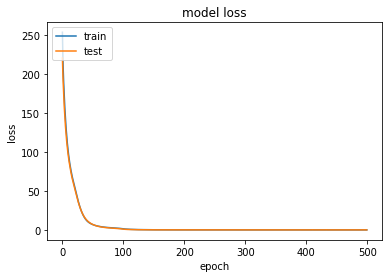

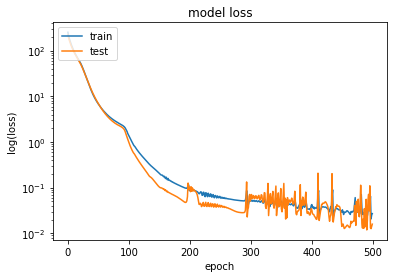

In [89]:
%matplotlib inline

# summarize history for loss
plt.figure(2)
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.figure(3)
plt.semilogy(model.history.history['loss'])
plt.semilogy(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('log(loss)')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')



### Test Performance of Neural Net

Here, we will generate new trajectories using a random starting condition. Using both an ode solver and our neural network, we will predict the trajectories of the points.

Text(0.5,0,'z coord')

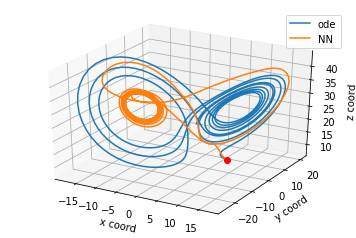

In [105]:
%matplotlib inline

y0 = 30*np.random.uniform(low=-0.5, high=0.5, size=3)

rho = 28

y_ode = scipy.integrate.odeint(func= lambda t,x: lorenz(t,x, rho), y0=y0, t=t, rtol=1e-10, atol=1e-11, tfirst=True)

y_NN = np.zeros(y_ode.shape)
y_NN[0, :] = y0


for i in range(1, y_NN.shape[0]):
    y_NN[i, :] = model.predict(np.expand_dims(y_NN[i-1, :], axis=1).T)

    
fig = plt.figure(4)
ax = fig.gca(projection='3d')

ax.plot(xs=y_ode[:, 0], ys=y_ode[:, 1], zs=y_ode[:, 2])
ax.plot(xs=y_NN[:, 0], ys=y_NN[:, 1], zs=y_NN[:, 2])
ax.plot([y0[0]], [y0[1]], [y0[2]], 'ro')
ax.legend(['ode', 'NN'])
plt.xlabel('x coord')
plt.ylabel('y coord')
ax.set_zlabel('z coord')

    


In [92]:
#save_me = y0